# Python 08 ‚Äî Introdu√ß√£o pr√°tica a Machine Learning com Python (Iris, scikit-learn e TensorFlow)

Este notebook √© uma aula completa e pr√°tica cobrindo conceitos b√°sicos de Machine Learning (ML) com Python, usando dois ecossistemas populares: **scikit-learn** (cl√°ssico/estat√≠stico) e **TensorFlow/Keras** (redes neurais). Trabalharemos com o conjunto de dados cl√°ssico **Iris**.

Objetivos:
- Entender os conceitos fundamentais de ML supervisionado (features, r√≥tulos, treino/teste, valida√ß√£o, m√©tricas).
- Explorar o dataset Iris e realizar EDA (An√°lise Explorat√≥ria de Dados) b√°sica.
- Treinar modelos com scikit-learn (Logistic Regression, SVC) usando boas pr√°ticas (Pipeline, padroniza√ß√£o, valida√ß√£o cruzada, Grid Search).
- Salvar e carregar modelos treinados.
- Treinar uma rede neural simples com TensorFlow/Keras e comparar resultados.

Pr√©-requisitos (recomendado): Python 3.9+ e as bibliotecas `numpy`, `pandas`, `matplotlib`, `seaborn`, `scikit-learn`, `tensorflow`.

## 0) Instala√ß√£o (opcional)
Se estiver rodando localmente e ainda n√£o tiver as depend√™ncias, execute a c√©lula abaixo. Ela usa o interpretador atual do Python para instalar os pacotes necess√°rios.

Observa√ß√£o: a instala√ß√£o do TensorFlow pode demorar e requer ambiente compat√≠vel. No Colab, geralmente n√£o √© necess√°rio.

In [ ]:
# Instala√ß√£o opcional de depend√™ncias (compat√≠vel com Colab e Jupyter)
# - Detecta Colab e instala pacotes necess√°rios usando o mesmo interpretador do kernel.
# - Se j√° tiver tudo instalado, pode pular.

from __future__ import annotations
import sys, subprocess

try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:  # noqa: BLE001
    IN_COLAB = False

PKGS = [
    'numpy', 'pandas', 'matplotlib', 'seaborn', 'scikit-learn', 'joblib', 'tensorflow'
]

def pip_install(pkgs: list[str]) -> None:
    cmd = [sys.executable, '-m', 'pip', 'install', '-q', '-U', *pkgs]
    print('Instalando:', ' '.join(pkgs))
    subprocess.check_call(cmd)

if IN_COLAB:
    print('Ambiente Colab detectado. As depend√™ncias j√° devem estar dispon√≠veis.')
    # pip_install(PKGS) # Descomente se precisar for√ßar a atualiza√ß√£o
else:
    print('Instala√ß√£o opcional ‚Äî pule se o ambiente j√° tiver as depend√™ncias.')


Ambiente Colab detectado. As depend√™ncias j√° devem estar dispon√≠veis.


## 1) Imports, Configura√ß√µes e Verifica√ß√£o de Vers√µes

- Importar bibliotecas e m√≥dulos.
- Definir sementes de aleatoriedade para reprodutibilidade.
- Verificar vers√µes para diagnosticar problemas de ambiente.

In [ ]:
import sys
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import sklearn

from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Configs de plot
#sns.set(theme="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (8, 5)

# Semente para reprodutibilidade
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Verifica√ß√£o de vers√µes
print("Python:", sys.version.split()[0])
print("Numpy:", np.__version__)
print("Pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)
print("TensorFlow:", tf.__version__)

Python: 3.12.11
Numpy: 2.0.2
Pandas: 2.2.2
scikit-learn: 1.6.1
TensorFlow: 2.19.0


## 2) Conceitos b√°sicos de ML supervisionado

- **Problema**: Classificar a esp√©cie de uma flor (Iris) a partir de suas medidas (features).
- **Features (X)**: Comprimento/largura de s√©palas e p√©talas (4 vari√°veis num√©ricas).
- **R√≥tulo/Target (y)**: Esp√©cie da flor (3 classes: setosa, versicolor, virginica).
- **Fluxo padr√£o**: Dividir dados em treino/teste, treinar o modelo nos dados de treino, validar e, finalmente, avaliar no conjunto de teste.
- **M√©tricas comuns**: Acur√°cia, precis√£o, revoca√ß√£o, F1-score.
- **Boas pr√°ticas**: Padroniza√ß√£o dos dados, valida√ß√£o cruzada, manter o conjunto de teste intocado at√© a avalia√ß√£o final.

## 3) Carregando o dataset Iris e An√°lise Explorat√≥ria R√°pida (EDA)

Usaremos `sklearn.datasets.load_iris` e o converteremos para um `pandas.DataFrame` para facilitar a inspe√ß√£o.

In [ ]:
iris = datasets.load_iris(as_frame=True)
df: pd.DataFrame = iris.frame.copy()
df.head()
df.tail()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

     target  
145       2  
146       2  
147       2  
148       2  
149       2

In [ ]:
print("Colunas:", list(df.columns))
print("Classes (target_names):", list(iris.target_names))
print("Descri√ß√£o resumida:\n", '\n'.join(iris.DESCR.split('\n')[0:5]))

# Mapear target num√©rico -> r√≥tulo textual para visualiza√ß√µes
df["species"] = df["target"].map(dict(enumerate(iris.target_names)))
df.sample(5, random_state=SEED)

Colunas: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'target']
Classes (target_names): [np.str_('setosa'), np.str_('versicolor'), np.str_('virginica')]
Descri√ß√£o resumida:
 .. _iris_dataset:

Iris plants dataset
--------------------



sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
73                 6.1               2.8                4.7               1.2   
18                 5.7               3.8                1.7               0.3   
118                7.7               2.6                6.9               2.3   
78                 6.0               2.9                4.5               1.5   
76                 6.8               2.8                4.8               1.4   

     target     species  
73        1  versicolor  
18        0      setosa  
118       2   virginica  
78        1  versicolor  
76        1  versicolor

### 3.1) Estat√≠sticas e Balanceamento de Classes

Vamos verificar as estat√≠sticas descritivas e se as classes est√£o balanceadas.

count unique     top freq      mean       std  min  25%  \
sepal length (cm)  150.0    NaN     NaN  NaN  5.843333  0.828066  4.3  5.1   
sepal width (cm)   150.0    NaN     NaN  NaN  3.057333  0.435866  2.0  2.8   
petal length (cm)  150.0    NaN     NaN  NaN     3.758  1.765298  1.0  1.6   
petal width (cm)   150.0    NaN     NaN  NaN  1.199333  0.762238  0.1  0.3   
target             150.0    NaN     NaN  NaN       1.0  0.819232  0.0  0.0   
species              150      3  setosa   50       NaN       NaN  NaN  NaN   

                    50%  75%  max  
sepal length (cm)   5.8  6.4  7.9  
sepal width (cm)    3.0  3.3  4.4  
petal length (cm)  4.35  5.1  6.9  
petal width (cm)    1.3  1.8  2.5  
target              1.0  2.0  2.0  
species             NaN  NaN  NaN

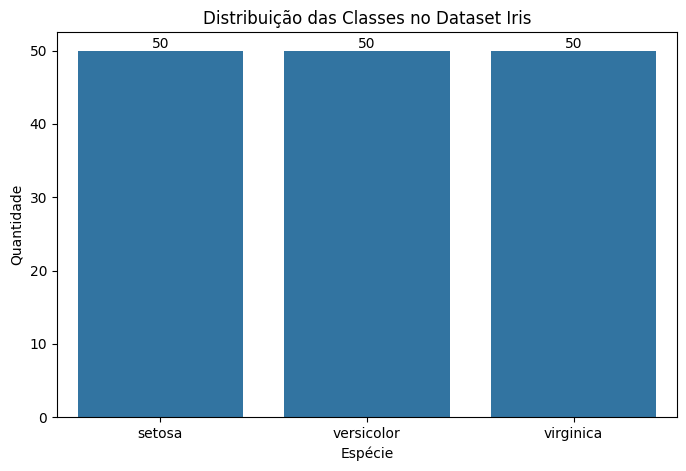

In [ ]:
# Estat√≠sticas descritivas
display(df.describe(include="all").T)

# Distribui√ß√£o de classes
plt.title("Distribui√ß√£o das Classes no Dataset Iris")
ax = sns.countplot(data=df, x="species", order=sorted(df.species.unique()))
ax.bar_label(ax.containers[0])
plt.xlabel("Esp√©cie")
plt.ylabel("Quantidade")
plt.show()

### 3.2) Rela√ß√µes entre vari√°veis

Um `pairplot` ajuda a visualizar a separabilidade entre as classes (pode demorar um pouco).

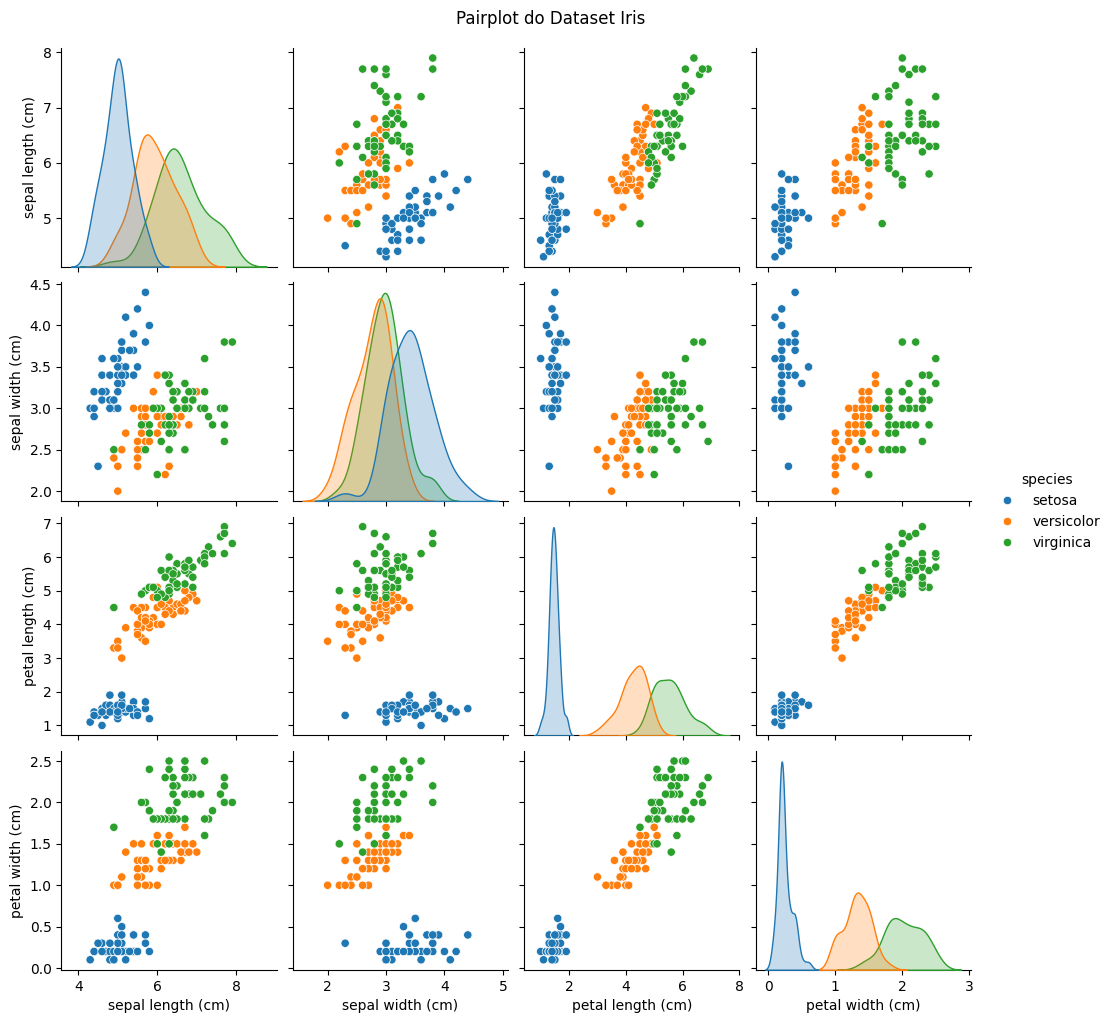

In [ ]:
sns.pairplot(df, vars=iris.feature_names, hue="species", diag_kind="kde")
plt.suptitle("Pairplot do Dataset Iris", y=1.02)
plt.show()

## 4) Treino/Teste, Pipeline e Primeiro Modelo (scikit-learn)

- Separa√ß√£o treino/teste com estratifica√ß√£o para manter a propor√ß√£o das classes.
- Uso de um `Pipeline` simples com Regress√£o Log√≠stica.
- M√©tricas: acur√°cia, relat√≥rio de classifica√ß√£o e matriz de confus√£o.

Shape de X_train: (120, 4)
Shape de X_test: (30, 4)
Acur√°cia (LogisticRegression): 0.9333

Relat√≥rio de classifica√ß√£o:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



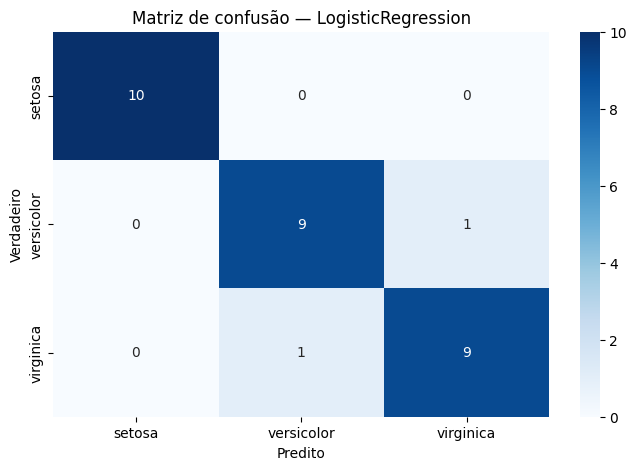

In [ ]:
# Features (X) e alvo (y)
X = df[iris.feature_names].to_numpy(dtype=np.float32)
y = df["target"].to_numpy(dtype=np.int64)

# Divis√£o em treino e teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de X_test: {X_test.shape}")

# Cria√ß√£o e treino do pipeline com Regress√£o Log√≠stica
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, random_state=SEED)),
])
pipe_lr.fit(X_train, y_train)

# Previs√£o e avalia√ß√£o
pred_lr = pipe_lr.predict(X_test)
acc_lr = accuracy_score(y_test, pred_lr)
print(f"Acur√°cia (LogisticRegression): {acc_lr:.4f}\n")

print("Relat√≥rio de classifica√ß√£o:\n", classification_report(y_test, pred_lr, target_names=iris.target_names))

# Matriz de confus√£o
cm = confusion_matrix(y_test, pred_lr)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.title("Matriz de confus√£o ‚Äî LogisticRegression")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.show()

üå± 1. Separa√ß√£o de Features e Alvo
python
X = df[iris.feature_names].to_numpy(dtype=np.float32)
y = df["target"].to_numpy(dtype=np.int64)
X: matriz com as vari√°veis preditoras (comprimento/largura de p√©talas e s√©palas).

y: vetor com os r√≥tulos das esp√©cies (0 = setosa, 1 = versicolor, 2 = virginica).

Convers√£o para NumPy arrays com tipos espec√≠ficos:

float32 para os dados num√©ricos.

int64 para os r√≥tulos.

‚úÇÔ∏è 2. Divis√£o em treino e teste
python
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
Divide os dados em:

80% para treino

20% para teste

stratify=y: garante que a propor√ß√£o de cada classe seja mantida em ambas as divis√µes.

random_state=SEED: garante reprodutibilidade.

üîß 3. Cria√ß√£o do pipeline
python
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, random_state=SEED)),
])
Pipeline: encadeia etapas de pr√©-processamento e modelagem.

StandardScaler(): padroniza os dados (m√©dia 0, desvio padr√£o 1).

LogisticRegression(): modelo de classifica√ß√£o linear.

max_iter=1000: n√∫mero m√°ximo de itera√ß√µes para converg√™ncia.

random_state=SEED: reprodutibilidade.

üß† 4. Treinamento do modelo
python
pipe_lr.fit(X_train, y_train)
Ajusta o pipeline aos dados de treino.

üìä 5. Previs√£o e avalia√ß√£o
python
pred_lr = pipe_lr.predict(X_test)
acc_lr = accuracy_score(y_test, pred_lr)
predict: gera previs√µes para os dados de teste.

accuracy_score: calcula a acur√°cia (propor√ß√£o de acertos).

üìã 6. Relat√≥rio de classifica√ß√£o
python
print(classification_report(y_test, pred_lr, target_names=iris.target_names))
Mostra m√©tricas como:

Precis√£o (precision)

Revoca√ß√£o (recall)

F1-score

Para cada classe (esp√©cie de flor).

üßÆ 7. Matriz de confus√£o
python
cm = confusion_matrix(y_test, pred_lr)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=iris.target_names, yticklabels=iris.target_names)
confusion_matrix: mostra os acertos e erros por classe.

sns.heatmap: visualiza a matriz como um mapa de calor.

Machine Learning com Python (resolu√ß√£o exerc√≠cio proposto)

Passo 1: Importar Bibliotecas e Carregar Dados
‚Ä¢ Usar bibliotecas como tensorflow, pandas e scikit-learn.
‚Ä¢ Carregar o conjunto de dados Iris dispon√≠vel no scikit-learn.

In [ ]:
# Importar bibliotecas
import tensorflow as tf
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
# Carregar conjunto de dados Iris
iris = load_iris()
X = iris.data
y = iris.target

Passo 2: Pr√©-processamento dos Dados
‚Ä¢ Dividir o conjunto de dados em treinamento e teste.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
random_state=42)

Normalizar os dados

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Passo 3: Construir o Modelo (Usar TensorFlow para construir um modelo de rede neural simples.)

In [ ]:
model = tf.keras.models.Sequential([
tf.keras.layers.Dense(10, activation='relu',
input_shape=(X_train.shape[1],)),
tf.keras.layers.Dense(10, activation='relu'),
tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

Passo 4: Treinar o Modelo
‚Ä¢ Treinar o modelo com os dados de treinamento

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=1)

Epoch 1/50
120/120 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step - accuracy: 0.3591 - loss: 1.1103
Epoch 2/50
120/120 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - accuracy: 0.7367 - loss: 0.9923
Epoch 3/50
120/120 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - accuracy: 0.7913 - loss: 0.7415
Epoch 4/50
120/120 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - accuracy: 0.8322 - loss: 0.5235
Epoch 5/50
120/120 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - accuracy: 0.8508 - loss: 0.4128
Epoch 6/50
120/120 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - accuracy: 0.8709 - loss: 0.3448
Epoch 7/50
120/120 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - accuracy: 0.8906 - loss: 0.2915
Epoch 8/50
120/120 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - accuracy: 0.8954 - loss:

Passo 5: Avaliar o Modelo
‚Ä¢ Avaliar a precis√£o do modelo usando os dados de teste.

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 538ms/step - accuracy: 1.0000 - loss: 0.0281
Loss: 0.028059901669621468
Accuracy: 1.0


Passo 6: Fazer Previs√µes
‚Ä¢ Fazer previs√µes com o modelo treinado.

In [ ]:
predictions = model.predict(X_test)
print("Previs√µes:")
print(predictions)

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 82ms/step
Previs√µes:
[[1.5267212e-04 9.9550802e-01 4.3394198e-03]
 [9.9994999e-01 4.9908911e-05 1.1120385e-08]
 [3.0117873e-14 7.7504437e-06 9.9999219e-01]
 [1.9721467e-04 9.6104312e-01 3.8759559e-02]
 [1.4976279e-05 9.8166895e-01 1.8315982e-02]
 [9.9984765e-01 1.5236581e-04 1.4304326e-08]
 [3.3543857e-03 9.9578053e-01 8.6513994e-04]
 [4.0854506e-08 1.0685070e-02 9.8931497e-01]
 [3.1709266e-07 8.0595809e-01 1.9404158e-01]
 [2.6356085e-04 9.9913716e-01 5.9918215e-04]
 [7.7390077e-06 1.1778367e-01 8.8220859e-01]
 [9.9987769e-01 1.2235263e-04 1.7787816e-09]
 [9.9996096e-01 3.9001079e-05 1.6906617e-09]
 [9.9989563e-01 1.0428808e-04 2.1585849e-09]
 [9.9997300e-01 2.6999152e-05 9.3990362e-09]
 [1.1360931e-03 9.6301389e-01 3.5850018e-02]
 [7.6408728e-09 2.1487398e-03 9.9785125e-01]
 [9.7826145e-05 9.9956065e-01 3.4145135e-04]
 [3.2471083e-04 9.8949271e-01 1.0182539e-02]
 [1.6448015e-09 1.0360284e-03 9.9896383e-01]
 [9.998774